Albert and the ear shells
=========================

Ear shells are marine snails.

The age of ear shells can be determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope - a boring and time-consuming task. 

**Albert**, a scientist and **ear shells** specialist, needs your help. He has collected data on his favorite sea creature and asks you to help him understand it. Then, he would like you to develop a model to predict the number of rings of ear shells (a proxy to their age) using other measurements which are easier to obtain.

# Part 0: Setup

Please include any setup code (including imports) in this section.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Part 1: Data understanding

## Loading, processing and exploring data

Albert has provided you the dataset `earshells.csv`. Please load it and do what every diligent Data Scientist should do when received a new dataset!

In [61]:
data = pd.read_csv('data/earshells.csv')
print(data.head())
data = data.drop_duplicates()
data['rings'] = data['rings'].fillna(data['rings'].mean())
data['price'] = data['price'].fillna(data['price'].mean())
print(data.isnull().sum())


  subset sex    length  diameter    height  weight_whole  weight_shucked  \
0  train   I  0.349544  0.260194  0.074504      0.179963        0.089707   
1  train   F  0.545249  0.439866  0.134915      0.918132        0.428983   
2   test   F  0.649654  0.544545  0.175080      1.524459        0.590134   
3  train   I  0.500003  0.394566  0.140912      0.621133        0.292336   
4  train   I  0.439268  0.335001  0.110040      0.389429        0.175157   

   weight_viscera  weight_shell  rings      price  
0        0.024760      0.054516    5.0   1.205721  
1        0.201751      0.237840   10.0  18.403463  
2        0.325970      0.495506   10.0  31.455767  
3        0.120165      0.195429    9.0   5.647747  
4        0.083279      0.110899    7.0   1.966989  
subset            0
sex               0
length            0
diameter          0
height            0
weight_whole      0
weight_shucked    0
weight_viscera    0
weight_shell      0
rings             0
price             0
dtype: int6

In [62]:
data_price_sorted_desc = data['price'].sort_values(ascending=False)
print(data_price_sorted_desc.head())

data_diameter_sorted_desc = data['diameter'].sort_values(ascending=False)
print(data_diameter_sorted_desc.head())

100     52.901790
2185    50.901227
960     49.611253
2961    49.105115
357     45.913030
Name: price, dtype: float64
2621    3.491197
2868    2.087074
1155    2.081404
2234    1.593748
3039    1.496710
Name: diameter, dtype: float64


## Questions

Albert needs your help getting a deeper understanding of one particular aspect of this data: the price of ear shells. Can you help him?

### Question 1.1

What's the **average price** for ear shells with a **diameter** falling outside the interquartile range (of diameter)?

In [63]:
Q1 = data['diameter'].quantile(0.25)
Q3 = data['diameter'].quantile(0.75)

In [64]:
outside_IQR = data[(data['diameter'] < Q1) | (data['diameter'] > Q3)]
average_price = outside_IQR['price'].mean()

print(f"The average price for earshells with diameters outside the IQR is: {average_price:.2f}CHF")

The average price for earshells with diameters outside the IQR is: 13.09CHF


### Question 1.2

Albert would like to understand which factors / attributes have been used to determine the price. Please provide him with **one clear visualization** which explicits the dependency between the price and the most relevant attributes.

To visualize the dependency between the price and the most relevant attributes, a correlation matrix is ideal! Albert can have a look at the last row of the matrix and clearly sees which feature is the most important.

Correlation of features with price:
weight_whole      0.926525
weight_shucked    0.898634
weight_shell      0.826825
length            0.738854
weight_viscera    0.702958
diameter          0.645403
rings             0.608447
height            0.355547
Name: price, dtype: float64
Top attributes correlated with price: ['weight_whole', 'weight_shucked', 'weight_shell']


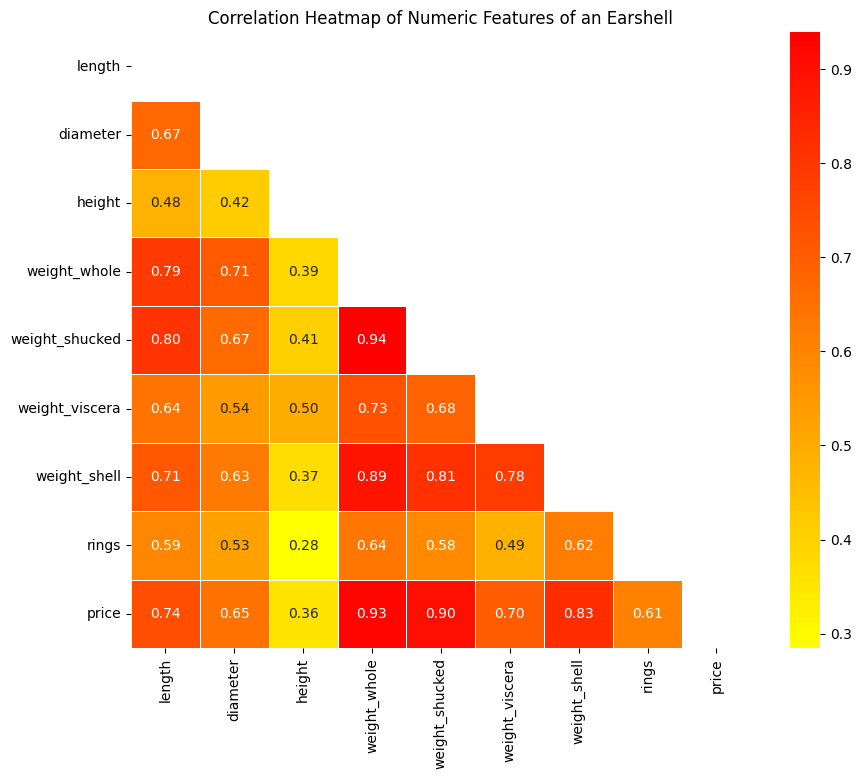

In [72]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numeric_cols].corr()
price_correlations = correlation_matrix['price'].drop('price').abs().sort_values(ascending=False)
print("Correlation of features with price:")
print(price_correlations)

top_attributes = price_correlations.index[:3].tolist()
print("Top attributes correlated with price:", top_attributes)

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # The upper part of the matrix may confuse poor Albert

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='autumn_r', linewidths=0.5)

plt.title('Correlation Heatmap of Numeric Features of an Earshell')
#plt.show()
plt.savefig('visu.png', bbox_inches='tight')

# Part 2: Modeling

Albert loves ML! He asks you to use your ML skills to train a model that will predict the **number of rings** based on the other attributes.

Albert was kind enough to pre-assign the dataset samples to train-test with the `subset` attribute. `test` samples should obviously not be used during the training procedure!

Please start with training a quick and easy model below and then spend some time to **fill out the questions** so we better understand your thought process.

In [66]:
train_data = data[data['subset'] == 'train'].copy()
test_data = data[data['subset'] == 'test'].copy()

In [67]:
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('subset')

print("Categorical columns:", categorical_cols)

combined_data = pd.concat([train_data, test_data], keys=['train', 'test'])

combined_data = pd.get_dummies(combined_data, columns=categorical_cols)

train_data_encoded = combined_data.xs('train')
test_data_encoded = combined_data.xs('test')


Categorical columns: ['sex']


In [68]:
y_train = train_data_encoded['rings']
y_test = test_data_encoded['rings']

X_train = train_data_encoded.drop(columns=['rings', 'subset'])
X_test = test_data_encoded.drop(columns=['rings', 'subset'])

print("Features in training set:", X_train.columns.tolist())

Features in training set: ['length', 'diameter', 'height', 'weight_whole', 'weight_shucked', 'weight_viscera', 'weight_shell', 'price', 'sex_F', 'sex_I', 'sex_M']


In [69]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=63)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=63)

In [70]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("Top 10 Feature Importances:")
print(feature_importance_df.head(10))

Top 10 Feature Importances:
           Feature  Importance
6     weight_shell    0.483377
7            price    0.116254
1         diameter    0.090102
4   weight_shucked    0.069780
2           height    0.058661
5   weight_viscera    0.053630
0           length    0.052318
3     weight_whole    0.040320
9            sex_I    0.028908
10           sex_M    0.005007


## Question 2.1

Which model will you choose to accomplish this task? Briefly explain why below.

The task is basically to predict a discrete variable representing the number of rings using the other attributes. For that, I used a Random Forest algorithm to perform a regression, which will use to most important features to make its predictions.

## Question 2.2

Which metric would you choose to communicate the performance of your model to Albert? Briefly explain why below.

Mean Absolute Error is the easiest for Albert to understand. A MAE of 0.86 means that the model, on average, predicts the correct number of rings +/- 0.86 ring.

## Question 2.3

How's your model performing? Please provide the value of your chosen metric on the **test samples** and briefly discuss it below.

In [71]:
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 0.86
Root Mean Squared Error (RMSE): 1.08
R-squared (R²): 0.57


An average error (MAE = 0.86) of less than one ring is relatively low.

An R² of 0.56 means that the model explains 56% of the variance in the number of rings, which is not a crazy high level of explanations.

# The end !

Thank you for participating in this challenge, we hope you enjoyed it!

Don't forget to upload your work at the link you got by mail:
- your notebook `challenge.ipynb`
- an image of your visualization for question 1.2
- a `requirements.txt` file listing your dependencies